In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

import statsmodels
from statsmodels.tsa.stattools import adfuller

import datetime as dt
from dateutil.parser import parse
import os 

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


sns.set()
pd.set_option('display.max_colwidth', None)

raw = r'..\data\RawZone\IMF'
data = 'data.csv'
m_data = 'masterdata.csv'


In [7]:
df = pd.read_csv(os.path.join(raw,data))
df['dt_ym'] = pd.to_datetime(df['dt_ym'])
df_md = pd.read_csv(os.path.join(raw,m_data))

C:\Users\danie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2006-01-01 00:00:00


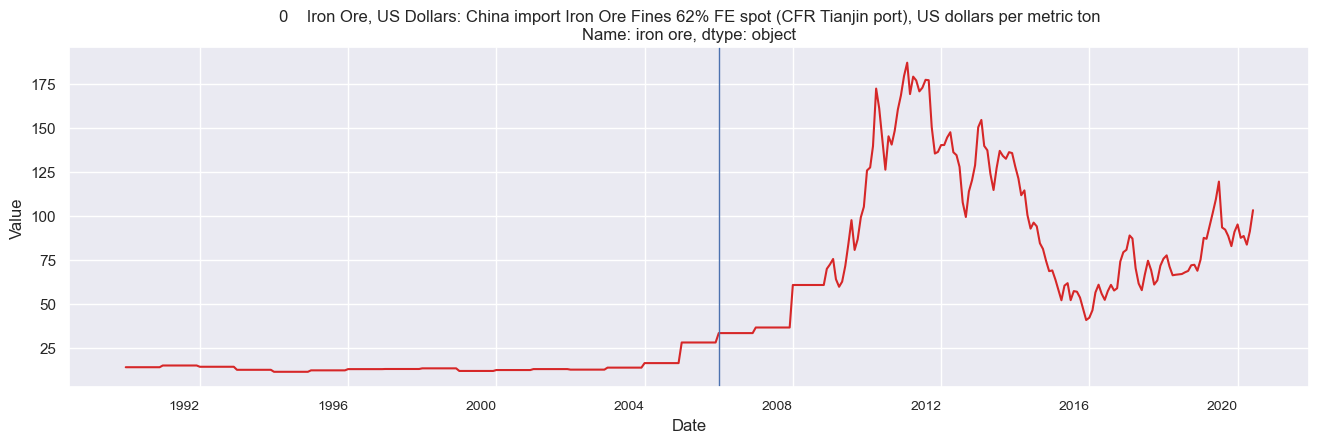

,iron ore,dt_ym,dt_y,dt_m
0,14.05,1990-01-01,1990-01-01,1
1,14.05,1990-02-01,1990-01-01,2
2,14.05,1990-03-01,1990-01-01,3
3,14.05,1990-04-01,1990-01-01,4
4,14.05,1990-05-01,1990-01-01,5


In [8]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100, **kwargs):
    vline = kwargs.get('vline')
    print(vline)
    fig, ax = plt.subplots(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.gcf().autofmt_xdate() 
    plt.setp(ax.get_xticklabels(), rotation = (0), fontsize = 10, ha='right')
    
    if vline is not None:
        plt.axvline(x=vline,linewidth=1, color='b')
    
    plt.show()
    
df_ir = df[['iron ore','dt_ym','dt_y','dt_m']]

df_ir['dt_y'] = pd.to_datetime(df['dt_y'], format='%Y')

plot_df(df,x=df_ir.dt_ym, y=df_ir['iron ore'],title=f"{df_md['iron ore']}",vline=dt.datetime(2006,1,1))

df_ir.head()

In [41]:
# create one step ahead inputs for LSTM
# the inputs for LSTM are t-1 and the outputs t
# the racionale for this is based on persistence models
# where xt(xt-1).

def shift_series(data, lag=1)-> pd.DataFrame:
    """
    This is a helper function to shift the dataset from n-lags.
    
    :param data:
    :param lag: 
    """
    
    df = pd.DataFrame(data)
    
    cols = [df.shift(i) for i in range(1, lag+1)] # n features 
    cols.append(df)
    
    df = pd.concat(cols, axis=1)
    df.fillna(0, inplace=True)
    
    return df.squeeze()
    
    
dataset = df[['dt_ym','iron ore']]
dataset.set_index('dt_ym', inplace=True)

ts = dataset.values
shift = shift_series(ts, 1)

shift.head()

,0,0
0,0.00,14.05
1,14.05,14.05
2,14.05,14.05
3,14.05,14.05
4,14.05,14.05


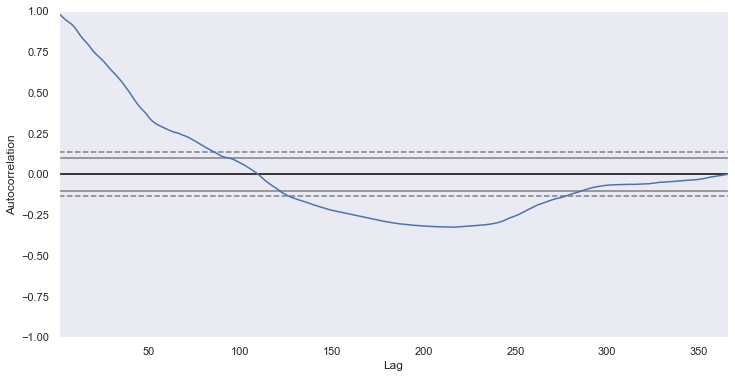

ADF Statistic: -1.502037
p-value: 0.532503
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


In [34]:
# Stationarity
fig = fig = plt.figure(figsize=(12,6))
pd.plotting.autocorrelation_plot(shift[0])
plt.show()

# ADF Test
result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

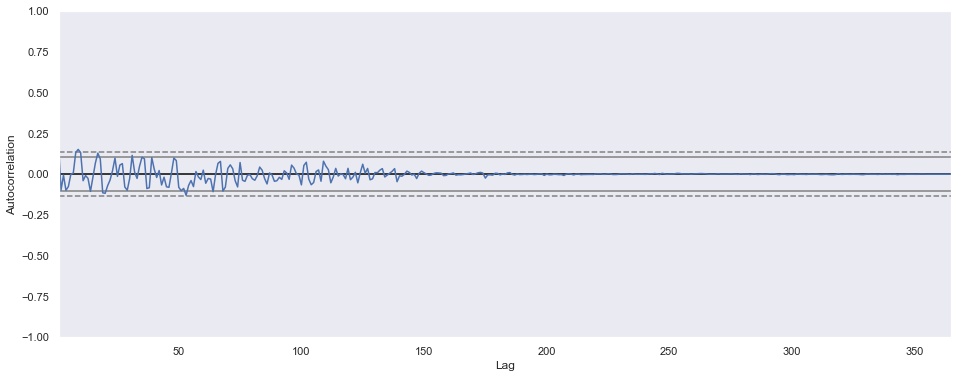

ADF Statistic: -4.472370
p-value: 0.000221
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


In [35]:
def get_diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return pd.Series(diff)

diff = get_diff(ts)

fig = fig = plt.figure(figsize=(16,6))
pd.plotting.autocorrelation_plot(diff)
plt.show()

# ADF Test
result = adfuller(diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

### Diferenciando a série uma vez ela é suficiente para torná-la estacionária

In [43]:
# In order to run LSTM we should transform the data 
# to be within the limits of the ANN activation function 
# the default activation function for LSTM is tanh C [-1,1]

def min_max_scaler(X, f_range=(-1,1)):
    scaler = MinMaxScaler(feature_range=f_range)
    scaler = scaler.fit(X)
    return scaler



scaler = min_max_scaler(ts)
X = scaler.transform(ts)


In [55]:
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [51]:
# https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# raw data 
dataset = df[['dt_ym','iron ore']]
dataset.set_index('dt_ym', inplace=True)
ts = dataset.values

# transform input to stationary
diff = get_diff(ts)

# shift series n times 
shift = shift_series(diff, 1)

# split train test 
size = int(len(X) * 0.80)
train, test = shift[0:size], shift[size:len(X)]

# MinMaxScaler
scaler = min_max_scaler(train)

#scale train
train = train.values.reshape(train.shape[0], train.shape[1])
train_scale = scaler.transform(train)


#scale test
test = test.values.reshape(test.shape[0], test.shape[1])
test_scale = scaler.transform(test)


# fit the model
lstm_model = fit_lstm(train_scale, 1, 3000, 4)


NameError: name 'train_scaled' is not defined

Month=1, Predicted=95.741247, Expected=92.852381
Month=2, Predicted=84.850737, Expected=96.260870
Month=3, Predicted=108.135826, Expected=94.142857
Month=4, Predicted=86.937846, Expected=84.522727
Month=5, Predicted=85.186240, Expected=81.304348
Month=6, Predicted=83.216922, Expected=74.425000
Month=7, Predicted=72.280543, Expected=68.673913
Month=8, Predicted=69.145795, Expected=69.068182
Month=9, Predicted=74.567416, Expected=63.800000
Month=10, Predicted=59.178415, Expected=58.181818
Month=11, Predicted=61.570923, Expected=52.113636
Month=12, Predicted=51.646520, Expected=60.428571
Month=13, Predicted=56.462755, Expected=61.840909
Month=14, Predicted=64.919999, Expected=52.173913
Month=15, Predicted=47.335785, Expected=57.333333
Month=16, Predicted=49.499444, Expected=56.977273
Month=17, Predicted=56.465341, Expected=53.659091
Month=18, Predicted=49.357392, Expected=47.190476
Month=19, Predicted=48.422922, Expected=40.882609
Month=20, Predicted=39.253363, Expected=42.204762
Month=21

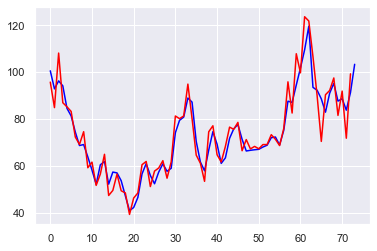

In [71]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scale[:, 0].reshape(len(train_scale), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()

for i in range(len(test_scale)):
    # make one-step forecast
    X, y = test_scale[i, 0:-1], test_scale[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(ts, yhat, len(test_scale)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = ts[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

mse = mean_squared_error(ts[size:-1], pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(ts[size:-1], pred)
r2 = r2_score(ts[size:-1], pred)

print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test R2: %.3f' % r2)

plt.plot(ts[size:], color='blue')
plt.plot(predictions, color='red')
plt.show()

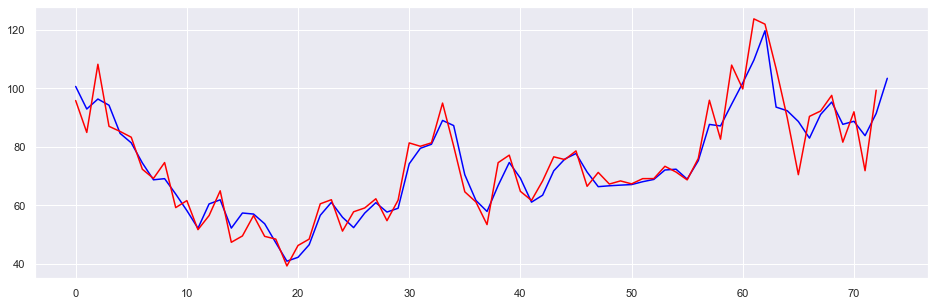

In [69]:
fig,axs =  plt.subplots(ncols=1, nrows=1, figsize=(16, 5))
plt.plot(ts[size:], color='blue')
plt.plot(predictions, color='red')
plt.show()

In [76]:
obs_df = dataset.iloc[size:-1]
obs_df['pred'] = predictions
obs_df['pred'] = obs_df['pred'].apply(lambda x: x[0])

obs_df.head()

C:\Users\danie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\danie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,iron ore,pred
dt_ym,,
2014-05-01,100.560000,95.741247
2014-06-01,92.852381,84.850737
2014-07-01,96.260870,108.135826
2014-08-01,94.142857,86.937846
2014-09-01,84.522727,85.186240


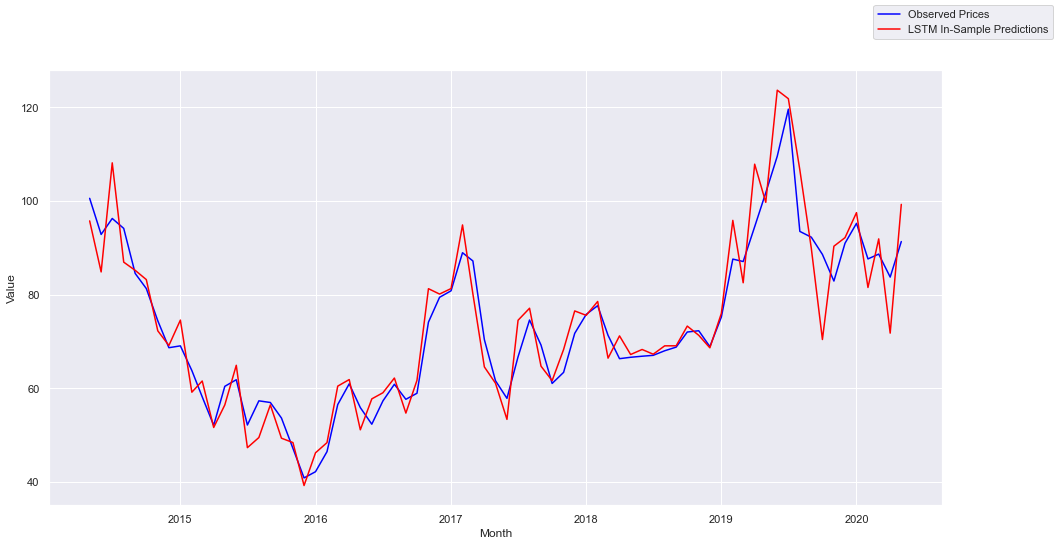

Test MSE: 31.144
Test RMSE: 5.581
Test MAE: 4.130
Test R2: 0.884


In [103]:
#plot
fig = plt.figure(figsize=(16,8))

sns.lineplot(x=obs_df.index, y='iron ore', data=obs_df, color='blue')
sns.lineplot(x=obs_df.index, y='pred', data=obs_df, color='red')
fig.legend(labels=['Observed Prices','LSTM In-Sample Predictions'])

plt.xlabel('Month')
plt.ylabel('Value')
plt.show()

print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test R2: %.3f' % r2)

In [102]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
pred = [predictions[i][0] for i in range(0, len(predictions))]

mse = mean_squared_error(ts[size:-1], pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(ts[size:-1], pred)
r2 = r2_score(ts[size:-1], pred)

print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test R2: %.3f' % r2)

#rmse = math.sqrt(mean_squared_error(ts[size:len(X)], predictions))
#print('Test RMSE: %.3f' % rmse)

Test MSE: 31.144
Test RMSE: 5.581
Test MAE: 4.130
Test R2: 0.884


In [104]:
pd.DataFrame({
    'Test MSE': mse,
    'Test RMSE': rmse,
    'Test MAE': mae,
    'Test R2': r2
}, index=['LSTM'])

,Test MSE,Test RMSE,Test MAE,Test R2
LSTM,31.143547,5.58064,4.129925,0.883783


In [105]:
pd.DataFrame({
    'Test MSE': mse,
    'Test RMSE': rmse,
    'Test MAE': mae,
    'Test R2': r2
}, index=['LSTM']).to_csv('./naive_lstm.csv')

In [122]:
arima = pd.read_csv('./naive_arima.csv')
lstm = pd.read_csv('./naive_lstm.csv')

modelos = pd.concat([arima,lstm],ignore_index=True).rename(columns={'Unnamed: 0': 'models'})
modelos.set_index('models')

,Test MSE,Test RMSE,Test MAE,Test R2
models,,,,
ARIMA,50.474962,7.104573,5.523321,0.817494
LSTM,31.143547,5.580640,4.129925,0.883783
